In [1]:
# import libraries
import torch
import numpy as np
from dataloader import get_dataloader_vae
from dataloader import get_dataloader_OOD
from utils import extract_feature_maps
from models import get_trained_model
#from energy import ELOOD
import matplotlib.pyplot as plt

c:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class for energy-like ood detection
class ELOOD:
    def __init__(self, model, T=10000):
        self.model = model.to(device)
        self.T = T
    
    # get energy function values
    # input size = [batch, n]
    # output size = [batch]
    def energy_vals(self, feats):
        # Perform element-wise division by T
        feats = np.divide(feats, self.T)      

        # Get the exponential of all values in the tensor
        feats = np.exp(feats)

        # Compute row-wise sum
        total = np.zeros(feats.shape[0])
        for i in range(feats.shape[0]):
            total[i] = np.sum(feats[i])
            # diving by number of elements to get avg
            total[i] = np.divide(total[i], np.prod(feats[i].shape)) 

        # Perform element-wise multiplication by T
        total = np.multiply(total, self.T)

        return total


    # get ood scores 
    def get_scores(self, loader):
        ood_scores = []
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            
            # get feature maps
            feats = extract_feature_maps(self.model, images)

            # get latent space representation
            _, _, _, z = self.model(images)

            # append z to feats
            feats.append(z.detach().cpu().data.numpy())

            # get energy function scores
            feats = [self.energy_vals(elem) for elem in feats]

            # compute sum
            total = np.zeros_like(feats[0])
            for elem in feats:
                total = np.add(total, elem)

            # get average
            total = np.divide(total, len(feats))   

            # find score for z
            z_energy = self.energy_vals(z.detach().cpu().data.numpy())

            # get scores
            scores = np.divide(z_energy, total)   

            # add scores to list
            ood_scores.extend(scores)

        return ood_scores

In [3]:
model = get_trained_model('CIFAR10')
# get dataloaders
train_dl, test_dl = get_dataloader_vae('CIFAR10')
svhn_dl = get_dataloader_OOD('SVHN')
det = ELOOD(model)

Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


In [4]:
print("for c10")
c10 = det.get_scores(train_dl)
print("for svhn")
sv = det.get_scores(svhn_dl)

for c10
for svhn


c:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
len(c10), len(sv)

(50000, 26032)

In [6]:
def statdesc(data):
    ## Statistical Descriptors

    # Mean
    mean = np.mean(data)
    print(f"Mean: {mean}")

    # Median
    median = np.median(data)
    print(f"Median: {median}")

    # Standard Deviation
    std_dev = np.std(data)
    print(f"Standard Deviation: {std_dev}")

    # Quartiles
    quartiles = np.quantile(data, [0.25, 0.5, 0.75])
    print(f"Quartiles: {quartiles}")

    # Interquartile Range (IQR)
    iqr = quartiles[2] - quartiles[0]
    print(f"Interquartile Range (IQR): {iqr}")

    # Minimum and Maximum
    data_min = np.min(data)
    data_max = np.max(data)
    print(f"Minimum: {data_min}")
    print(f"Maximum: {data_max}")

In [7]:
statdesc(c10)
print()
statdesc(sv)

Mean: 1.0004289616749518
Median: 1.0003681812548142
Standard Deviation: 0.0003011949864980076
Quartiles: [1.00022018 1.00036818 1.00057137]
Interquartile Range (IQR): 0.00035118497367947477
Minimum: 0.9997308199694082
Maximum: 1.0019133167130565

Mean: 1.0005940901489943
Median: 1.0003748083707267
Standard Deviation: 0.0005444998050939431
Quartiles: [1.00015464 1.00037481 1.00112733]
Interquartile Range (IQR): 0.0009726917204135876
Minimum: 0.9997132072444885
Maximum: 1.002134607987501


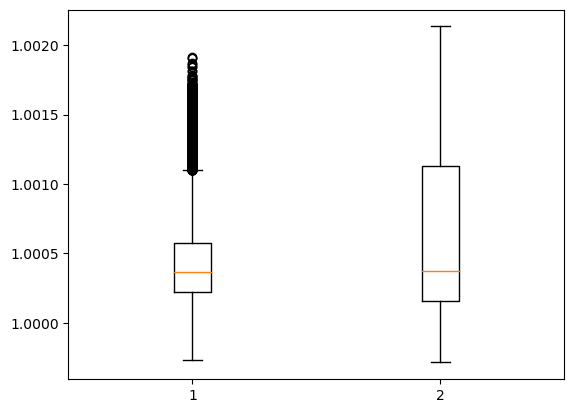

In [8]:
# Plot
plt.boxplot([c10, sv])

# Display the plot
plt.show()